# Desafio Cientista de Dados INDICIUM - Davi Ribeiro

## Price Prediction

In this dataset we have the variables: *'id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro', 'latitude', 'longitude', 'room_type', 'price', 'minimo_noites', 'numero_de_reviews', 'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365'*, but only some of them can be usefull for predicting the price.

Firstly, eliminating those that cannot help and may even confuse the model, they are:
- **_'id'_** (is used only to represent the user, but as it is a number, can affect the model);
- **_'nome'_** (the name of the place, it doesn't affect the price of the place);
- **_'host_id'_** (similar to the id of the rent ad, is used only to represent the place's owner, but can affect the model);
- **_'host_name'_** (the name of the owner's place doesn't affect the price of the place);
- **_'bairro_group'_** (the '_bairro_' variable is enough to represent the place's location);
- '**_latitude_**' and '**_longitude_**' (both are coordinates, but as a number can affect the model, and we already have the '_bairro_' and '*bairro_group*');
- '**_ultima_review_**' (is only the date of the last review, it doesn't affect the price of the place), 
- '**_reviews_por_mes_**' (how many reviews per month, it doesn't affect the price of the place);
- '**_calculado_host_listings_count_**' (the number of places that the owner has doens't affect the price of a place).

With this, we have the following variables to predict the price:
- **_'bairro'_**;
- **_'room_type'_**;
- **_'price'_** (the variable we want to predict);
- **_'minimo_noites'_**
- **_'numero_de_reviews'_**
- **_'disponibilidade_365'_**
  
Since in this problem we are not predicting categories, we are predicting the price which is a continuous variable, we will use some regression model.

### Importing Libraries

In [4]:
import warnings
warnings.filterwarnings("ignore")

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv("teste_indicium_precificacao.csv")
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [6]:
# First removing the unnecessary columns
df.drop(
    columns=['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'latitude', 
             'longitude', 'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count'], 
    inplace=True
    )

In [7]:
df.isna().sum()

bairro                 0
room_type              0
price                  0
minimo_noites          0
numero_de_reviews      0
disponibilidade_365    0
dtype: int64

First of all, we have some categorical variables, so we have to transform them into numeric variables, but we have a difficult situation on our hands. The variable *'bairro'* has 221 different values, but on this problem I think that the small granularity of the *'bairro'* is a big problem talking about dimensionality, , but it will probably be a good resource for predicting the price, bacause if I restrict it to *'bairro_group'*, I will lose a lot of information, for example two _'bairros'_ on Brooklyn, but one has more violent crimes than the other, using Brooklyn instead of using the _'bairros'_ will make the model miss this information. So, I'm going to use the *'bairro'* as a feature to predict the price. I will use the **_One Hot Encoding_** to transform the categorical variable into numerical variable, this may increase the cost of the model, but I think that it will be worth the pity.

As I know that dimensionality is a problem, I will change the type of columns to make better use of memory.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bairro               48894 non-null  object
 1   room_type            48894 non-null  object
 2   price                48894 non-null  int64 
 3   minimo_noites        48894 non-null  int64 
 4   numero_de_reviews    48894 non-null  int64 
 5   disponibilidade_365  48894 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.2+ MB


In [9]:
for col in df.columns[2:]:
    print(f'{col} - Min: {df[col].min()} - Max: {df[col].max()}')

price - Min: 0 - Max: 10000
minimo_noites - Min: 1 - Max: 1250
numero_de_reviews - Min: 0 - Max: 629
disponibilidade_365 - Min: 0 - Max: 365


With this minimum and maximum information for each column, we can use the correct type to save memory space:

- uint8 is from 0 to 255;
- uint16 is from 0 to 65535;
  
So we can use uint8 for the columns that have a maximum of 255 and uint16 for the columns that have a maximum of 65535

In [10]:
# Using price as integer only because the price on this dataset doensn't have float values
df['price'] = df['price'].astype('uint16')
df['minimo_noites'] = df['minimo_noites'].astype('uint16')
df['numero_de_reviews'] = df['numero_de_reviews'].astype('uint16')
df['disponibilidade_365'] = df['disponibilidade_365'].astype('uint16')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bairro               48894 non-null  object
 1   room_type            48894 non-null  object
 2   price                48894 non-null  uint16
 3   minimo_noites        48894 non-null  uint16
 4   numero_de_reviews    48894 non-null  uint16
 5   disponibilidade_365  48894 non-null  uint16
dtypes: object(2), uint16(4)
memory usage: 1.1+ MB


We can see that only changing types, our memory usage is 50% smaller.

In [12]:
# Applying the One-Hot-Encoding on the columns room_type and bairro
df = pd.concat((df, pd.get_dummies(df['room_type'], dtype=np.uint8)), axis=1).drop(columns=['room_type'])
df = pd.concat((df, pd.get_dummies(df['bairro'], dtype=np.uint8)), axis=1).drop(columns=['bairro']).reset_index(drop=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Columns: 228 entries, price to Woodside
dtypes: uint16(4), uint8(224)
memory usage: 10.8 MB


Doing One-Hot Encoding, we can see that we went from 6 columns to 228, and memory usage increased almost 10x, but as I said before, this is expected, and I think it will be worth it.

In [14]:
from tabulate import tabulate

# Function to print the metrics for the regression models
def regression_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred).round(2)
    rmse = root_mean_squared_error(y_true, y_pred).round(2)
    r2 = r2_score(y_true, y_pred).round(2)

    metrics_data = [
        ['Root Mean Squared Error', rmse],
        ['Mean Absolute Error', mae],
        ['R-squared', r2],
    ]

    table = tabulate(metrics_data, headers=['Metric', 'Score'], tablefmt='pretty')

    print("Regression Report:")
    print(table)
    
    return rmse, mae, r2

For metrics, I will use 3 to look at, but only 2 for real evaluation, they are Root Mean Squared(RMSE) and R-Squared(r2). I'm using RMSE because it's a good metric that measures mean squared errors, but when the root is applied the error measure is on the same scale as its variable, so if my RMSE is 50, it means I'm predicting wrong on average. 50+ or 50-. And I like to use R2 because it's a good statistical measure to see if the percentage of actual variation in the data is similar to the prediction, so closer to 1 is better.

In [15]:
# Splitting the data between features and target
X = df.drop(columns=['price']).values
y = df['price'].values

In [16]:
# Splitting the data between train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Let's normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Using joblib to save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

To load the scaler is very simple:

```scaler = joblib.load('scaler.pkl')```

### Using the models

#### Gradient Boosting Regressor

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

In [20]:
rmse_gbr, mae_gbr, r2_gbr = regression_report(y_test, gbr.predict(X_test))

Regression Report:
+-------------------------+--------+
|         Metric          | Score  |
+-------------------------+--------+
| Root Mean Squared Error | 213.47 |
|   Mean Absolute Error   | 66.01  |
|        R-squared        |  0.09  |
+-------------------------+--------+


#### Support Vector Regressor

In [21]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)

SVR()

In [22]:
rmse_svr, mae_svr, r2_svr = regression_report(y_test, svr.predict(X_test))

Regression Report:
+-------------------------+--------+
|         Metric          | Score  |
+-------------------------+--------+
| Root Mean Squared Error | 216.01 |
|   Mean Absolute Error   | 58.82  |
|        R-squared        |  0.07  |
+-------------------------+--------+


#### Random Forest Regressor

In [23]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

RandomForestRegressor()

In [24]:
rmse_random_forest, mae_random_forest, r2_random_forest = regression_report(y_test, random_forest.predict(X_test))

Regression Report:
+-------------------------+--------+
|         Metric          | Score  |
+-------------------------+--------+
| Root Mean Squared Error | 233.96 |
|   Mean Absolute Error   | 68.89  |
|        R-squared        |  -0.1  |
+-------------------------+--------+


#### XGBoost Regressor

In [25]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=1000, max_depth=7, random_state=42, learning_rate=0.001, n_jobs = -1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [26]:
rmse_xgb, mae_xgb, r2_xgb = regression_report(y_test, xgb.predict(X_test))

Regression Report:
+-------------------------+--------------------+
|         Metric          |       Score        |
+-------------------------+--------------------+
| Root Mean Squared Error | 214.82000732421875 |
|   Mean Absolute Error   | 71.51000213623047  |
|        R-squared        |        0.08        |
+-------------------------+--------------------+


We can see that these regressors are not good, with R-Squared close to zero and RMSE greater than 200, let's try to make a Neural Network to predict the values.

#### Neural Network

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tqdm import tqdm

In [33]:
# Callback function to save the best model based best RMSE

class SaveBestModel(Callback):
    def __init__(self,filepath_weights):
        super(SaveBestModel, self).__init__()
        self.filepath_weights = filepath_weights
        self.best_metric = 1e3

    def on_epoch_end(self, epoch, logs=None):
        val_metric = logs['val_root_mean_squared_error']
        if val_metric < self.best_metric:
            self.best_metric = val_metric
            self.model.save_weights(f"{self.filepath_weights}_{(self.best_metric) :.2f}.h5", overwrite=True)
            print(f"\nModel saved with validation accuracy: {val_metric:.4f}")


In [34]:
# Creating the Neural Network

model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation="relu",))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu"))

opt = tf.optimizers.Adam(learning_rate=5e-3)
loss_fn = tf.keras.losses.Huber() # Less sensitive to outliers than MSE
rmse_metric = tf.keras.metrics.RootMeanSquaredError()
r2_metric = tf.keras.metrics.MeanSquaredError()

model.compile(optimizer=opt, loss=loss_fn, metrics=[rmse_metric, r2_metric])

model.summary()


Model: "sequential"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                14592     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16705 (65.25 KB)
Trainable params: 16705 (65.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Simple NN, but I believe that for this problem, is enough.

In [35]:
epochs = 1000
hist = model.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test),
                 callbacks=[SaveBestModel(filepath_weights='model_weights')],
                 batch_size=128,
                 verbose=1)


Epoch 1/1000

261/306 [========================>.....] - ETA: 0s - loss: 82.7742 - root_mean_squared_error: 248.0725 - mean_squared_error: 61539.9883
Model saved with validation accuracy: 213.3608
306/306 [==============================] - 1s 1ms/step - loss: 80.9530 - root_mean_squared_error: 244.9126 - mean_squared_error: 59982.1836 - val_loss: 56.4860 - val_root_mean_squared_error: 213.3608 - val_mean_squared_error: 45522.8359
Epoch 2/1000
306/306 [==============================] - 0s 1ms/step - loss: 69.4610 - root_mean_squared_error: 236.9053 - mean_squared_error: 56124.1133 - val_loss: 55.8949 - val_root_mean_squared_error: 213.5704 - val_mean_squared_error: 45612.3086
Epoch 3/1000
306/306 [==============================] - 0s 1ms/step - loss: 68.9154 - root_mean_squared_error: 237.0186 - mean_squared_error: 56177.8125 - val_loss: 56.6180 - val_root_mean_squared_error: 214.8838 - val_mean_squared_error: 46175.0312
Epoch 4/1000
306/306 [==============================] - 0s 1ms/ste

In [33]:
# Save the model on a .pkl file
joblib.dump(model, 'model_neural_network.pkl')

['model_neural_network.pkl']

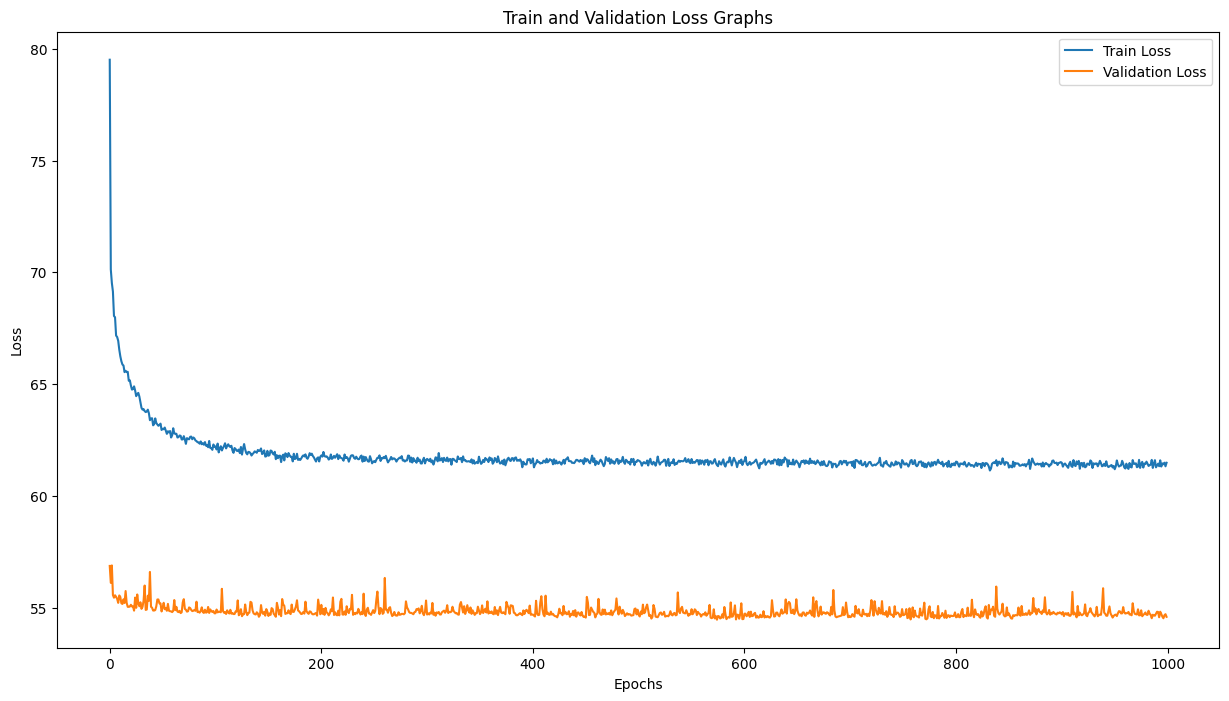

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss Graphs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


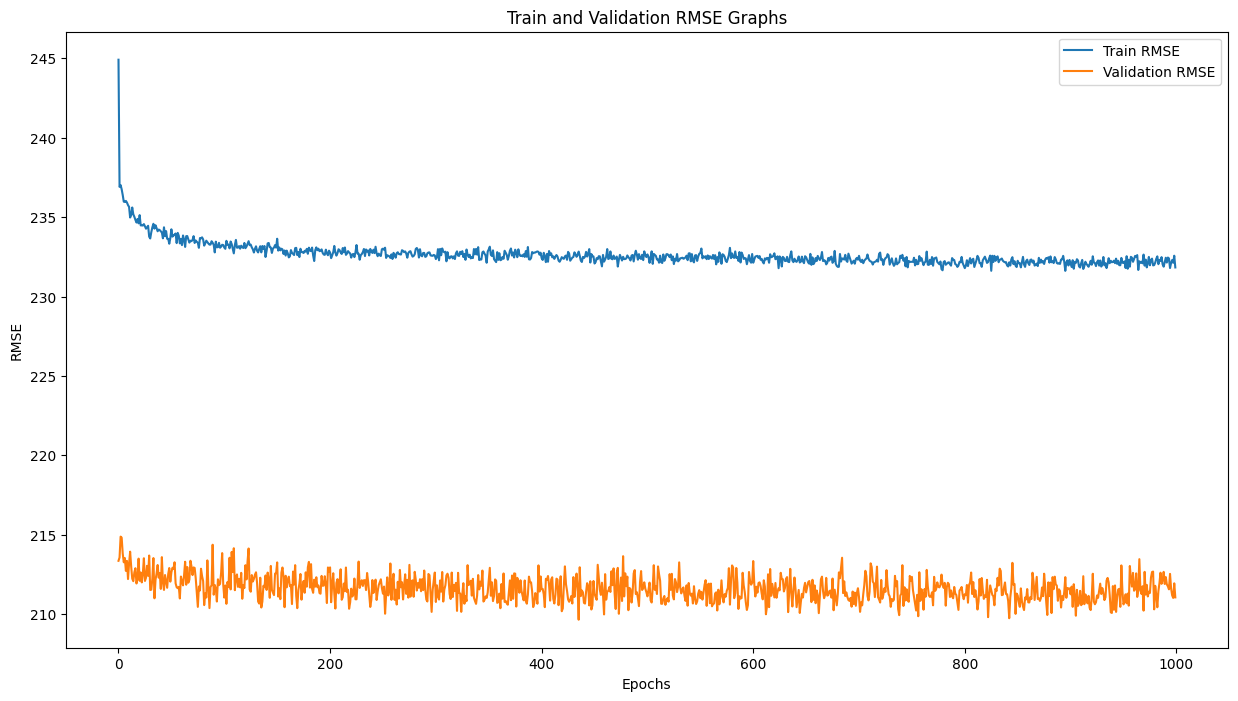

In [36]:
plt.figure(figsize=(15, 8))
plt.plot(hist.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Train and Validation RMSE Graphs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()


In [32]:
rmse_nn, mae_nn, r2_nn = regression_report(y_test, model.predict(X_test, verbose=0))

Regression Report:
+-------------------------+--------------------+
|         Metric          |       Score        |
+-------------------------+--------------------+
| Root Mean Squared Error | 208.8699951171875  |
|   Mean Absolute Error   | 60.959999084472656 |
|        R-squared        |        0.13        |
+-------------------------+--------------------+


#### Testing the model on this single case

In [38]:
test = pd.read_csv('test.csv')
test.drop(
    columns=['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'latitude', 
             'longitude', 'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count'], 
    inplace=True
    )
test

,bairro,room_type,price,minimo_noites,numero_de_reviews,disponibilidade_365
0,Midtown,Entire home/apt,225,1,45,355


In [39]:
# These variables are necessary for the One-Hot-Encoding part
unique_room_type = df['room_type'].unique()
unique_bairro = df['bairro'].unique()

test = pd.concat((test, pd.get_dummies(test['room_type'], dtype=np.uint8)), axis=1).drop(columns=['room_type'])
test = pd.concat((test, pd.get_dummies(test['bairro'], dtype=np.uint8)), axis=1).drop(columns=['bairro'])


In [40]:
# This is for get the columns that are missing
missing_columns = set(np.concatenate((unique_room_type, unique_bairro))) - set(test.columns)
for column in missing_columns:
    test[column] = np.uint8(0)

In [41]:
# Loading the scaler saved on the beginning of the notebook
scaler_ = joblib.load('models-scalers/scaler_default.pkl')

In [42]:
X_ = test.drop(columns=['price']).values
X_ = scaler_.transform(X_)

In [44]:
# Loading the model saved above
model = joblib.load('models-scalers/model_neural_network_1.pkl')

Important point, for the model and the scaler to work well, the data must be in the same structure as the training here, which is why all the above treatment was necessary.

In [49]:
real = test['price'][0]
predicted = model.predict(X_, verbose=0)[0][0]

print(f"Real: {real:.2f}, Predicted: {predicted:.2f}")
print(f"Difference: {abs(real - predicted):.2f}")

Real: 225.00, Predicted: 286.93
Difference: 61.93


The performance of the model in general is not very good, but on this case, the performance of the model wasn't bad, the price was predicted with an error of 61.93, which is not bad, but it's not good either.

#### Performance Summary

In [41]:
model_summary = pd.DataFrame(columns=['model', 'RMSE', 'R²'])
model_summary.loc[0] = ['Gradient Boosting', rmse_gbr, r2_gbr]
model_summary.loc[1] = ['Support Vector Machine', rmse_svr, r2_svr]
model_summary.loc[2] = ['Random Forest', rmse_random_forest, r2_random_forest]
model_summary.loc[3] = ['XGBoost', rmse_xgb, r2_xgb]
model_summary.loc[4] = ['Neural Network', rmse_nn, r2_nn]
model_summary.sort_values(by='RMSE')

,model,RMSE,R²
4,Neural Network,208.869995,0.13
0,Gradient Boosting,213.470000,0.09
3,XGBoost,214.820007,0.08
1,Support Vector Machine,216.010000,0.07
2,Random Forest,233.960000,-0.10


The pros and cons of using a neural network here are:

- **Pros**:
    - Non-linearity (but as you can see I only used non-linear regressors);
    - Flexibility (I used a simple architecture, because that was enough, but I could make a bigger and more complex model);
- **Cons**:
    - High computational cost (Training can be slow and require significant computational resources);
    - If you are not careful, it is very easy to overfit;
    - Sometimes requires a lot of data to work well.

As we can see, the Neural Network is better than the other regressors, and this is expected, because the Neural Network is a very flexible model, and it can learn the data better than the other models but it is still not good enough. I believe that as we saw in the EDA notebook, this data set has a large number of outliers, so the variance of the data is large and this is affecting the accuracy of the models. So, trying to solve this, I made another notebook with exactly the same layout as this one, but removing the outliers.

One important thing to say is that the outliers that we saw in the boxplots are above the maximum fence, which means they were the high-value locations, which means that probably by removing the outliers, I'm removing some luxury rental locations, but I'm sure that by removing them the variance will decrease and the accuracy of the models will be better.